In [5]:
pip install langchain-chroma bs4 requests

  Using cached beautifulsoup4-4.14.2-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.8-py3-none-any.whl.metadata (4.6 kB)
Using cached beautifulsoup4-4.14.2-py3-none-any.whl (106 kB)
Using cached soupsieve-2.8-py3-none-any.whl (36 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [bs4]
Note: you may need to restart the kernel to use updated packages.


### EMBEDDINGS CREATION AND STORING

In [2]:
import os, getpass

def set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
llm = ChatOpenAI(model="gpt-4o-mini")

vector_store = Chroma(
    collection_name = "example_collection",
    embedding_function = embeddings,
    persist_directory = "long_term_db",
)


In [7]:
import bs4 
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader(
    web_path=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content","post-title","post-header")
        )
    ),
)

doc = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
all_splits = text_splitter.split_documents(doc)

In [8]:
all_splits[0:2]

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [9]:
_ = vector_store.add_documents(documents=all_splits)

### RETRIEVAL

In [11]:
results = vector_store.similarity_search(
    "what is task decomposition ?",
    k=1,
)
results

[Document(id='fb8a757e-6530-49f7-8cd9-0b7090191dcd', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of 

In [14]:
from langchain_core.tools.retriever import create_retriever_tool

retriever = vector_store.as_retriever(search_kwargs={"k":2})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retriever_article_info_tool",
    description="Retrieve some information from Lilian Weng's article",
)

In [16]:
retriever.invoke("what is the task of decomposition?")

[Document(id='fb8a757e-6530-49f7-8cd9-0b7090191dcd', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of 

In [17]:
retriever_tool.invoke("what is the task of decomposition?")

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\nSelf-Reflection#\n\nCompo

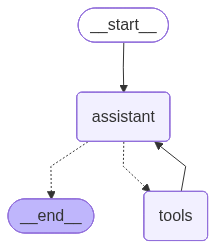

In [18]:
from pprint import pprint
from IPython.display import display, Image

from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

llm_with_tool = llm.bind_tools([retriever_tool])

def assistant(state: MessagesState):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

workflow = StateGraph(MessagesState)

workflow.add_node("assistant",assistant)
workflow.add_node("tools", ToolNode([retriever_tool]))

workflow.add_edge(START,"assistant")
workflow.add_conditional_edges("assistant", tools_condition,)
workflow.add_edge("tools", "assistant")

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
results = graph.invoke({"messages": "What is the task of decomposition ?"})

In [24]:
print(results["messages"][-1].content)

The task of decomposition involves breaking down complex tasks into smaller, more manageable steps. This helps in planning and effectively executing complicated tasks. 

Here are key aspects of task decomposition:

1. **Planning**: Knowing the steps involved in a task allows for better planning and execution.

2. **Chain of Thought (CoT)**: This technique encourages models to think step by step, making it easier to tackle hard tasks by transforming them into simpler, manageable tasks. 

3. **Tree of Thoughts**: An extension of CoT, this method explores multiple reasoning possibilities at each step, creating a tree structure where different thoughts are generated for each step. It can use search processes like breadth-first or depth-first search.

4. **Methods of Decomposition**: 
   - Through simple prompts such as "Steps for XYZ" or "What are the subgoals for achieving XYZ?"
   - Using task-specific instructions (e.g., "Write a story outline").
   - With human inputs.

5. **LLM+P Appr